- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter kernel (`ms_classification`)
  - (created in `0_setup.ipynb`)

---

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.2,
    rc={
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans']
    }
)
sns.set_palette('colorblind')

# set manuscript-ready style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.linewidth': 1.2,
    'grid.alpha': 0.3
})

---

In [2]:
# write down .pkl with baseline variant_test_data for analyses where others are N/A
#
#cp100 = pd.read_pickle('x4_cal-test_combos__100x_cp__per_variant_test_data__cp_instance_col.pkl')
#cp100['ps_size'] = cp100['classes'].apply(len)
#cp100[(cp100['variant_test_data']=='baseline')].to_pickle('x4_cal-test_combos__100x_cp__only_baseline_variant_test_data__cp_instance_col.pkl')

cp100 = pd.read_pickle('x4_cal-test_combos__100x_cp__only_baseline_variant_test_data__cp_instance_col.pkl')
print(cp100.columns)
print(cp100.cal_test.unique())

Index(['dataset', 'scan_id', 'slice_idx', 'class', 'predicted_class',
       'is_correct', 'pred_prob_0', 'pred_prob_1', 'actual_class_pred_prob',
       'variant_test_data', 'model', 'confidence', 'credibility', 'margin',
       'classes', 'verdict', 'class_conditional', 'cp', 'run', 'cal_test',
       'ps_size'],
      dtype='object')
['dv3T-cal_dv3T-test' 'baseline3T-cal_dv3T-test'
 'baseline3T-cal_dv1.5T-test' 'dv1.5T-cal_dv1.5T-test']


---

---

- only looking at baseline
- only look at matched (valid) cal/test
- look at overall coverage
- look at coverage by class
- stratify by 3T vs 1.5T
- stratify by class 0 vs 1
- stratify by marginal vs class-conditional coverage 

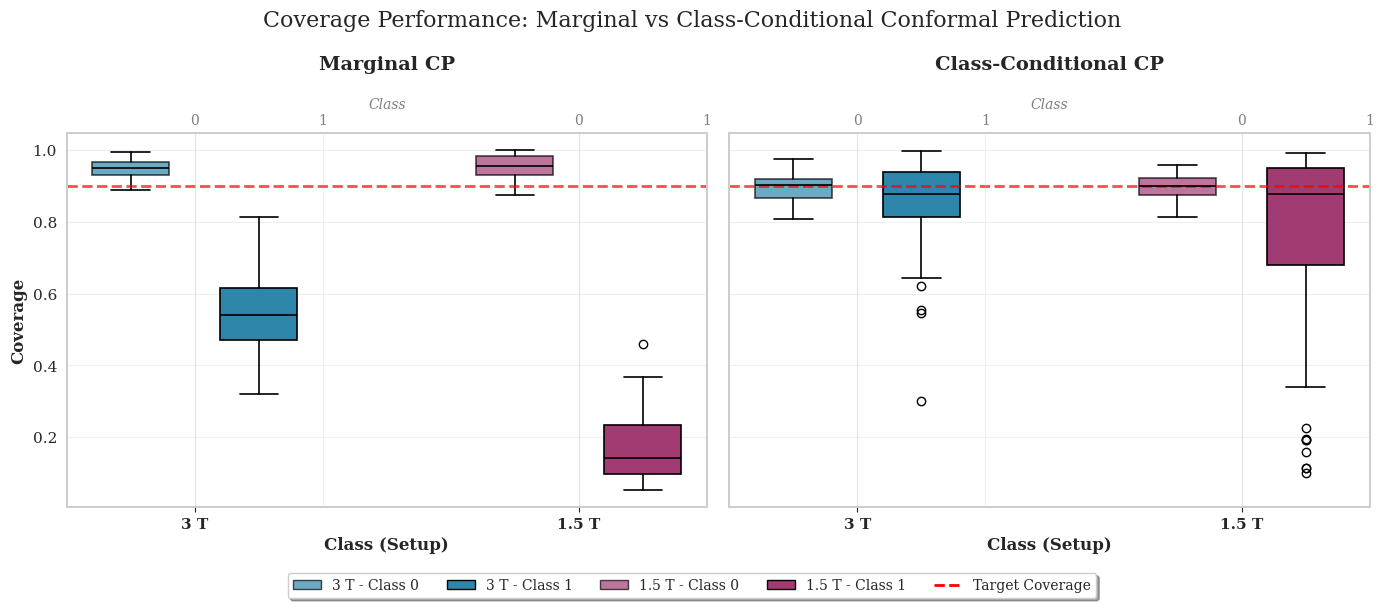

,cal_test,class_conditional,class,mean_coverage,median_coverage,coverage_std,undercoverage_pct,severe_undercoverage_pct
0,dv1.5T-cal_dv1.5T-test,Marginal,0,0.952,0.954,0.032,6.0,0.0
1,dv1.5T-cal_dv1.5T-test,Marginal,1,0.169,0.142,0.087,100.0,100.0
2,dv1.5T-cal_dv1.5T-test,Class-Conditional,0,0.895,0.898,0.033,51.0,0.0
3,dv1.5T-cal_dv1.5T-test,Class-Conditional,1,0.775,0.878,0.240,56.0,37.0
4,dv3T-cal_dv3T-test,Marginal,0,0.946,0.948,0.024,3.0,0.0
5,dv3T-cal_dv3T-test,Marginal,1,0.542,0.540,0.112,100.0,99.0
6,dv3T-cal_dv3T-test,Class-Conditional,0,0.894,0.901,0.036,49.0,0.0
7,dv3T-cal_dv3T-test,Class-Conditional,1,0.858,0.877,0.113,59.0,22.0


In [3]:
def box_plots(df):
    # Calculate coverage per run
    coverage_data = (
        df.groupby(['cal_test', 'class_conditional', 'run', 'class'])['verdict']
        .mean()
        .reset_index()
    )
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle('Coverage Performance: Marginal vs Class-Conditional Conformal Prediction', 
                 fontsize=16, y=0.98)
    
    # Define colors for better contrast
    colors = {
        'dv3T-cal_dv3T-test': '#2E86AB',      # Blue
        'dv1.5T-cal_dv1.5T-test': '#A23B72'   # Purple
    }
    
    # Plot settings
    class_conditional_labels = {False: 'Marginal CP', True: 'Class-Conditional CP'}
    setup_labels = {
        'dv3T-cal_dv3T-test': 'DV3T Setup',
        'dv1.5T-cal_dv1.5T-test': 'DV1.5T Setup'
    }
    
    for i, (class_cond, ax) in enumerate(zip([False, True], axes)):
        subset = coverage_data[coverage_data['class_conditional'] == class_cond]
        
        # Create boxplot
        box_plot = ax.boxplot([
            subset[(subset['cal_test'] == 'dv3T-cal_dv3T-test') & (subset['class'] == 0)]['verdict'],
            subset[(subset['cal_test'] == 'dv3T-cal_dv3T-test') & (subset['class'] == 1)]['verdict'],
            subset[(subset['cal_test'] == 'dv1.5T-cal_dv1.5T-test') & (subset['class'] == 0)]['verdict'],
            subset[(subset['cal_test'] == 'dv1.5T-cal_dv1.5T-test') & (subset['class'] == 1)]['verdict']
        ], positions=[1, 2, 4, 5], widths=0.6, patch_artist=True)
        
        # Color the boxes
        box_colors = [colors['dv3T-cal_dv3T-test'], colors['dv3T-cal_dv3T-test'],
                      colors['dv1.5T-cal_dv1.5T-test'], colors['dv1.5T-cal_dv1.5T-test']]
        alphas = [0.7, 1.0, 0.7, 1.0]  # Lighter for class 0, darker for class 1
        
        for patch, color, alpha in zip(box_plot['boxes'], box_colors, alphas):
            patch.set_facecolor(color)
            patch.set_alpha(alpha)
            patch.set_edgecolor('black')
            patch.set_linewidth(1.2)
        
        # Style whiskers, caps, and medians
        for element in ['whiskers', 'caps', 'medians']:
            for item in box_plot[element]:
                item.set_color('black')
                item.set_linewidth(1.2)
        
        # Add horizontal reference line at 0.9 (typical target coverage)
        ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, linewidth=2, 
                   label='Target Coverage (0.90)')
        
        # Customize axes
        ax.set_title(f'{class_conditional_labels[class_cond]}', fontweight='bold', pad=20)
        ax.set_xlabel('Class (Setup)', fontweight='bold')
        if i == 0:
            ax.set_ylabel('Coverage', fontweight='bold')
        
        # Set x-axis labels
        ax.set_xticks([1.5, 4.5])
        ax.set_xticklabels(['3 T', '1.5 T'], fontweight='bold')
        
        # Add minor ticks for classes
        ax2 = ax.twiny()
        ax2.set_xticks([1, 2, 4, 5])
        ax2.set_xticklabels(['0', '1', '0', '1'], fontsize=10, color='gray')
        ax2.set_xlabel('Class', fontsize=10, color='gray', style='italic')
        ax2.tick_params(length=0)
        
        # Set y-axis limits to show undercoverage clearly
        # ax.set_ylim(0.0, 1.0)
        ax.grid(True, alpha=0.3)
    
    # Create custom legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor=colors['dv3T-cal_dv3T-test'], alpha=0.7, 
                      edgecolor='black', label='3 T - Class 0'),
        plt.Rectangle((0,0),1,1, facecolor=colors['dv3T-cal_dv3T-test'], alpha=1.0, 
                      edgecolor='black', label='3 T - Class 1'),
        plt.Rectangle((0,0),1,1, facecolor=colors['dv1.5T-cal_dv1.5T-test'], alpha=0.7, 
                      edgecolor='black', label='1.5 T - Class 0'),
        plt.Rectangle((0,0),1,1, facecolor=colors['dv1.5T-cal_dv1.5T-test'], alpha=1.0, 
                      edgecolor='black', label='1.5 T - Class 1'),
        plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Target Coverage')
    ]
    
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=5, frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('9-2-1__Coverage Performance__Marginal vs Class-Conditional Conformal Prediction.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

def calculate_coverage_stats(df, target_coverage=0.90):
    stats = []
    
    for (cal_test, class_cond, class_val), group in df.groupby(['cal_test', 'class_conditional', 'class']):
        coverage_values = group.groupby('run')['verdict'].mean()
        
        stats.append({
            'cal_test': cal_test,
            'class_conditional': 'Class-Conditional' if class_cond else 'Marginal',
            'class': class_val,
            'mean_coverage': coverage_values.mean(),
            'median_coverage': coverage_values.median(),
            'coverage_std': coverage_values.std(),
            'undercoverage_pct': (coverage_values < target_coverage).mean() * 100,
            'severe_undercoverage_pct': (coverage_values < (target_coverage - 0.10)).mean() * 100
        })
    
    return pd.DataFrame(stats)


# filter
df = cp100[cp100['cal_test'].isin([
    'dv3T-cal_dv3T-test',
    'dv1.5T-cal_dv1.5T-test'
])]

box_plots(df)
calculate_coverage_stats(df).round(3)

---

---

---

---

---